In [1]:
# Step 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import nltk
import string
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Step 2: Load Dataset
true_news = pd.read_csv('True.csv')
fake_news = pd.read_csv('Fake.csv')
real_news = pd.read_csv('additional_real_news.csv')

true_news['label'] = 1
fake_news['label'] = 0
real_news['label'] = 1

# Combine datasets
news_data = pd.concat([true_news, fake_news, real_news], ignore_index=True)
news_data = news_data[['title', 'text', 'label']].dropna()

# Shuffle full dataset
news_data = news_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Balance the dataset
min_count = min(news_data['label'].value_counts().values)
balanced_real = news_data[news_data['label'] == 1].sample(n=min_count, random_state=42)
balanced_fake = news_data[news_data['label'] == 0].sample(n=min_count, random_state=42)
news_data = pd.concat([balanced_real, balanced_fake]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced Label Distribution:")
print(news_data['label'].value_counts())

Balanced Label Distribution:
label
0    21507
1    21507
Name: count, dtype: int64


In [5]:
# Print the first 5 rows of the dataframe
news_data.head()

,title,text,label
0,Ex-DOJ Lawyer Just Dropped The Most Depressin...,While most Americans are aware that Donald Tru...,0
1,UNHINGED LIBERAL Uses The ‘N-Word’ On Live TV ...,,0
2,Trump expected to make VP announcement on Frid...,WASHINGTON (Reuters) - Presumptive Republican ...,1
3,Trump Just Told Prince Charles To Eat Sh*t Fo...,Donald Trump is slated to visit Great Britain ...,0
4,RETIRED COP PENS Gut-Wrenching VIRAL Letter To...,It s easy to see why this letter went viral. B...,0


In [7]:
# Print the last 5 rows of the dataframe
news_data.tail()

,title,text,label
43009,'Strong' Franco-British defense relationship w...,PARIS (Reuters) - Britain s exit from the Euro...,1
43010,U.S. Representative Levin says he will not run...,WASHINGTON (Reuters) - U.S. Representative San...,1
43011,NRA Had This To Say After ANOTHER School Shoo...,The National Rifle Association (NRA) has been ...,0
43012,Exclusive: U.S. envoys told to be coy on re-en...,WASHINGTON (Reuters) - U.S. diplomats should s...,1
43013,Panama says Odebrecht paid ex-president's sons...,PANAMA CITY (Reuters) - Two sons of former Pan...,1


In [9]:
# Number of rows and colums
news_data.shape

(43014, 3)

In [11]:
# Getting some basic information about the data
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43014 entries, 0 to 43013
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   43014 non-null  object
 1   text    43014 non-null  object
 2   label   43014 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1008.3+ KB


In [13]:
# Checking the number of missing values
news_data.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [15]:
# Step 3: Preprocessing Function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove links
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)           # Retain acronyms like NASA, numbers
    tokens = nltk.word_tokenize(text)
    clean_text = [lemmatizer.lemmatize(word) for word in tokens if word.lower() not in stop_words]
    return ' '.join(clean_text)

In [17]:
# Step 4: Apply Preprocessing and Split
news_data['combined_text'] = news_data['title'].fillna('') + " " + news_data['text'].fillna('')
news_data['clean_text'] = news_data['combined_text'].astype(str).apply(preprocess_text)

X = news_data['clean_text']
y = news_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
print(X)
print(y)

0        exdoj lawyer dropped depressing truth bomb tru...
1        unhinged liberal us nword live tv try push fal...
2        trump expected make vp announcement friday sou...
3        trump told prince charles eat sht absolutely r...
4        retired cop pen gutwrenching viral letter 49er...
                               ...                        
43009    strong francobritish defense relationship wont...
43010    u representative levin say run reelection wash...
43011    nra say another school shooting took place ame...
43012    exclusive u envoy told coy reengaging paris cl...
43013    panama say odebrecht paid expresidents son 49 ...
Name: clean_text, Length: 43014, dtype: object
0        0
1        0
2        1
3        0
4        0
        ..
43009    1
43010    1
43011    0
43012    1
43013    1
Name: label, Length: 43014, dtype: int64


In [21]:
# Step 5: Build Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        max_df=0.85,
        min_df=2,
        ngram_range=(1, 2),
        max_features=10000
    )),
    ('svc', LinearSVC(C=0.5, max_iter=5000))
])

In [23]:
# Step 6: Train Model
pipeline.fit(X_train, y_train)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.85, max_features=10000, min_df=2,
                                 ngram_range=(1, 2), stop_words='english')),
                ('svc', LinearSVC(C=0.5, max_iter=5000))])


Model Performance on Test Data:

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4249
           1       0.99      0.99      0.99      4354

    accuracy                           0.99      8603
   macro avg       0.99      0.99      0.99      8603
weighted avg       0.99      0.99      0.99      8603


ROC-AUC Score: 0.9939632098038578


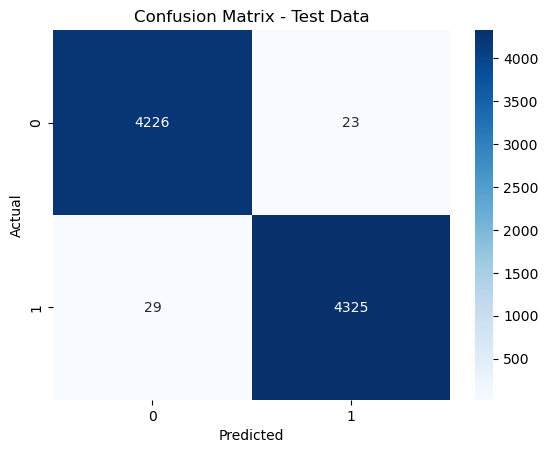

In [25]:
# Step 7: Evaluate on Test Data
y_test_pred = pipeline.predict(X_test)

print("\nModel Performance on Test Data:")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_test_pred))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Model Performance on Training Data:

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     17258
           1       1.00      1.00      1.00     17153

    accuracy                           1.00     34411
   macro avg       1.00      1.00      1.00     34411
weighted avg       1.00      1.00      1.00     34411


ROC-AUC Score: 0.9986345883375283


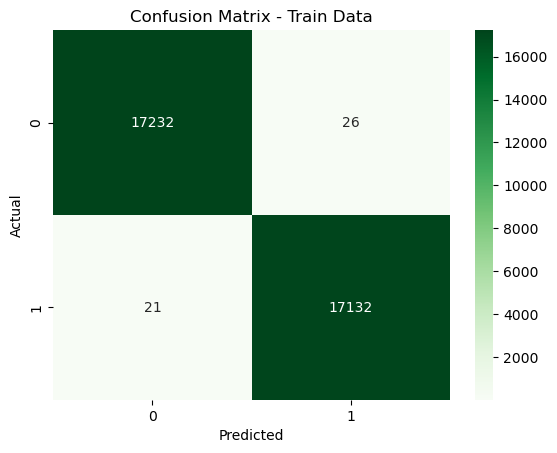

In [26]:
# Step 8: Evaluate on Train Data
y_train_pred = pipeline.predict(X_train)

print("\nModel Performance on Training Data:")
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print("\nROC-AUC Score:", roc_auc_score(y_train, y_train_pred))
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Train Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [37]:
# Step 9: Model Prediction
input_news = ["""NASA's new Mars rover, Perseverance, has successfully landed on the red planet and is set to explore the Martian surface in search of signs of past life."""]
input_cleaned = [preprocess_text(text) for text in input_news]
prediction = pipeline.predict(input_cleaned)
print("\nPrediction for Input News:", prediction)
print("This news article is", "REAL!" if prediction[0] == 1 else "FAKE!")


Prediction for Input News: [1]
This news article is REAL!


In [33]:
# Step 9: Save Model
joblib.dump(pipeline, 'fake_news_pipeline.pkl')
print("Model trained and saved successfully.")

Model trained and saved successfully.
